<a href="https://colab.research.google.com/github/MapleWolfe/Anomaly_detection_waymo_open/blob/main/anomoly_autoencoder_model/autoencoder_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Model for Waymo open dataset
- please see the auto_encoder_readme.md

##### Enviornment Notebook was built in:
- Kindly run this notebook in Google Colab

##### Hardware needs:

- Kindly use a minimum of 12 GB CPU ram
- the standard Nvidia T4 GPU that comes with the free version of Google Colab.
- 50 GB disk Minimum (less should work but this was the minimum during notebook creation)

##### following files should be in local directory if using the local notebook
- these files should be in the same folder as notebook

##### instructions to run notebook,
- Kindly fill in the code cell below to use the local parquet files stored in the same folder as notebook or the parquet files stored in a GCS bucket

In [24]:
# do you want to use local sample files or google cloud storage?
file_store = 'GCS' # kindly use either 'GCS' for Google cloud storage or 'LOCAL' for files stored in the same folder as notebook

# leave both as None if using LOCAL or kindly replace this with your GCS api key json file and Bucket name or else
gcs_json_key = 'google_key.json' # please remember to start file path here with '/content/' + your json key file name
bucket_name = 'waymo_sample_bucket'

#these are the file download limits, it limits the number of parquet files being downloaded for training / validation / test
train_limit = 40 #-1 means all relevant files in your google bucket
val_limit = 10 #-1 means all relevant files in your google bucket
test_limit = 1 #-1 means all relevant files in your google bucket


# the path below is to the sample files: there are 4 parquets in total, the waymo_sample_data folder from github repo
train_box_data_file_path  = 'waymo_sample_data/training/camera_box/training_camera_box_10017090168044687777_6380_000_6400_000.parquet'
train_image_data_file_path = 'waymo_sample_data/training/camera_image/training_camera_image_10017090168044687777_6380_000_6400_000.parquet'
val_box_data_file_path = 'waymo_sample_data/validation/camera_box/validation_camera_box_10203656353524179475_7625_000_7645_000.parquet'
val_image_data_file_path = 'waymo_sample_data/validation/camera_image/validation_camera_image_10203656353524179475_7625_000_7645_000.parquet'


## installs, imports, pre-sets

- kindly open and run cell blocks based on the enviornment being run in to save computational resources.

### Using detect_model_requirements.txt
- please uncomment to use

In [2]:
# uncomment to create notebook package requirments file called detect_model_requirements.txt
#!pip freeze > detect_model_requirements.txt

# use the code below to use detect_model_requirements.txt to install all necessary packages
#!pip install -r detect_model_requirements.txt

### Neccessary installs on top of google colab
- uncomment and Run this cell if you aren't using detect_model_requirements.txt and are operating in the GPU google colab enviornment

In [3]:
#!pip install google-cloud-storage
#!pip install altair

### Imports

In [88]:
# installs for google cloud storage
from google.cloud import storage

# general tool installs
import os, io, shutil, warnings, zipfile, json
from tqdm.notebook import tqdm

#image processing and plotting libraries
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# data processing librarires
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

# model evaluation
from sklearn.model_selection import ParameterGrid

# model libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#pre-sets
warnings.filterwarnings("ignore")
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU_count:' ,len(physical_devices))

GPU_count: 1


## utility functions
- functions that may be used at a later point

### delete file function

In [5]:
# code to delete a file
def delete_file(file_path_list):
  for a_file in (file_path_list):
    os.remove(a_file)
  return None

### move copy function

In [6]:
def move_copy(old_location, new_location):
  shutil.copy(old_location, new_location)
  return None

### download blob function

In [7]:
# to download a blob file
def download_blob(a_blob,file_name):
  a_blob.download_to_filename(file_name)
  return None

### Let's create folder directory for Autoencoder

In [8]:
#folder name list for directory
def make_directory(folder_name_list):
  folder_path = os.path.join(*folder_name_list)
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  return None

#function to build directory structure
def build_a_directory():
  for folder_type in ['train','test','eval']:
    for data_type in ['images']:
      make_directory(['datasets',folder_type,data_type])
  return None



In [9]:
# running directory function
build_a_directory()

## Google Cloud Storage section

- Run these cells if you are using your private google cloud storage.
- kindly ensure that your bucket has the same structure and file names as the waymo_open_dataset_v_2_0_0 bucket

In [10]:
def start_gcs(gcs_json_key = gcs_json_key, bucket_name = bucket_name):
# Please input API JSON KEY FOR your private google cloud storage where the files are kept in gcs_json_key defined in the first codeblock
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = gcs_json_key
    client = storage.Client()
# replace the bucket name with the bucket name in your GCS, use the bucket_name object  in the first codeblock
    bucket = client.get_bucket(bucket_name)

#getting file list
    files = bucket.list_blobs()
    files_list = [a_file.name for a_file in files]
    return bucket, files_list


### GCS Iterative File Dowload function
(Bare Image parquet and Bounding box parquet files)

In [11]:
# in the following function we are creating blobs: one blob object for images parquet and another blob for box coordinates parquet
def open_gcs_file(files_list,bucket, storage_folder = 'training'):
    # lets ensure that we have the correct file type
    if storage_folder not in ['training','testing','validation']:
      print('''please retype storage_folder it should either be ('training','testing','validation') in the second parameter of function)''')
      return None

    image_box_str = storage_folder +'/'+ 'camera_box'+'/'
    bare_image_str = storage_folder +'/'+ 'camera_image'+'/'
    print('files_list: ', files_list)
    for a_file in files_list:
        if image_box_str in a_file:
          try:
            box_file_name = a_file
            box_file_blob = bucket.blob(box_file_name)
            bare_image_file_name = box_file_name.replace(image_box_str, bare_image_str)
            bare_image_blob = bucket.blob(bare_image_file_name)
            if bare_image_blob is not None:
              yield box_file_blob, os.path.basename(box_file_name),bare_image_blob, os.path.basename(bare_image_file_name)
          except:
            continue


## Storing files for autoencoder model
- functions to unpack and store from parquet files

### save path and create unique key function

In [12]:
# creating a save path
def create_path(file_id,store_type, images_labels = 'images'):
  if store_type == 'train':
    if images_labels == 'images':
      return 'datasets/train/images/' +str(file_id) + '.jpg'
    else:
      return 'datasets/train/labels/' +str(file_id) + '.txt'

  elif store_type == 'eval':
    if images_labels == 'images':
      return 'datasets/eval/images/' +str(file_id) + '.jpg'
    else:
      return 'datasets/eval/labels/' +str(file_id) + '.txt'
  elif store_type == 'train':
    if images_labels == 'images':
      return 'datasets/train/images/' +str(file_id) + '.jpg'
    else:
      return 'datasets/train/labels/' +str(file_id) + '.txt'
  else:
    print('error type parameter: train / eval / test')

# creating a key column
def create_key_column(select_df):
  return select_df['key.segment_context_name'].astype(str) +  select_df['key.frame_timestamp_micros'].astype(str) + select_df['key.camera_name'].astype(str)


### Building image pre-processing functions

In [13]:
# this effectively converts all pixels within the bounding box into black pixels
def blackout_bounding_boxes(df, image_array):
    for index, row in df.iterrows():
        center_x = int(row['center_x'])
        center_y = int(row['center_y'])
        width = int(row['size_x'])
        height = int(row['size_y'])

        x1 = int(center_x - width / 2)
        y1 = int(center_y - height / 2)
        x2 = int(center_x + width / 2)
        y2 = int(center_y + height / 2)

        image_array[y1:y2, x1:x2] = 0

    return image_array



#### Unpacking, scaling, storing images and annotations seperately

In [14]:
# building bounding box labels
# here we are also scaling the bounding box positions to the new image of 640 x 640
def build_save_labels(df,image_size):
  width, height = image_size
  df.loc[:,'center_x'] = (df.loc[:,'[CameraBoxComponent].box.center.x'] * (640/width))
  df.loc[:,'center_y'] = (df.loc[:,'[CameraBoxComponent].box.center.y'] * (640/height))
  df.loc[:,'size_x'] = (df.loc[:,'[CameraBoxComponent].box.size.x'] * (640/width))
  df.loc[:,'size_y'] = (df.loc[:,'[CameraBoxComponent].box.size.y'] * (640/height))

  select_col_df = df[['[CameraBoxComponent].type','center_x','center_y','size_x','size_y']]
  return select_col_df



# constructing and saving image to path we are
# here we are checking the image size and resizing it to 640 x 640
# here we are also converting images to grayscale
# here weare also
def build_save_image(byte_string, box_df, image_path):
  image_bytes = io.BytesIO(byte_string)
  image = Image.open(image_bytes)
  original_image_size = image.size

  if (original_image_size[0] %32 == 0) and (original_image_size[1] %32 == 0):
    #creating scaled bounding boxes
    bounding_box_df = build_save_labels(box_df,original_image_size)

    # resizing and greyscaling
    resized_image = image.resize((640,640))
    gray_img = np.mean(np.array(resized_image), axis=2, dtype=np.uint8)
    #blackout areas within bounding boxes
    blackout_img_array = blackout_bounding_boxes(bounding_box_df, gray_img)

    # lets save image
    output_image = Image.fromarray(blackout_img_array)
    output_image.save(image_path)
    return image_path


In [28]:
# combining all functions above
def unpack_store_images(image_parquet,box_parquet, store_type = 'train',id_gain = 0):
  file_path_store = []
  image_df = pd.read_parquet(image_parquet)
  box_df = pd.read_parquet(box_parquet)

  image_df.loc[:,'key_column'] = create_key_column(image_df)
  box_df.loc[:,'key_column'] = create_key_column(box_df)

  commmon_key_list = list(set(box_df['key_column'].tolist()) & set(image_df['key_column'].tolist()))
  id_iterator = 0 + id_gain
  for common_key in tqdm(commmon_key_list):
    key_loc_image = image_df.loc[image_df['key_column'] == common_key]
    image_bytes = key_loc_image.reset_index().loc[0, '[CameraImageComponent].image']

    key_loc_box = box_df.loc[box_df['key_column'] == common_key]
    image_path = create_path(id_iterator,store_type, images_labels = 'images')


    saved_path = build_save_image(image_bytes,key_loc_box,image_path)
    if saved_path is not None:
      file_path_store.append(saved_path)

    id_iterator +=1
  return file_path_store, id_iterator

## building model

In [16]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, code_size=4, decoder_output_shape=1):
        super().__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(code_size, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(decoder_output_shape, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


In [17]:
def train_model(file_counter, model_path, batch = 1, epoch = 10):
  batch_size = batch
  data_generator = ImageDataGenerator(rescale=1.0/255)
  train_data = data_generator.flow_from_directory('/content/datasets/train/',batch_size= batch,class_mode='input', color_mode='grayscale', target_size=(640, 640))
  validation_data = data_generator.flow_from_directory('/content/datasets/eval/',batch_size= batch,class_mode='input', color_mode='grayscale', target_size=(640, 640))

  if file_counter == 0:
    model = AutoEncoder()
    model.compile(loss='msle', metrics=['mse'], optimizer='adam')

    fitted_encoder_history = model.fit(train_data, steps_per_epoch=train_data.samples // batch,
      epochs=epoch,validation_data=validation_data, validation_steps=validation_data.samples // batch)

    model.save(model_path,save_format="tf" )
    return model_path

  else:
    model = tf.keras.models.load_model(model_path)
    model.compile(loss='msle', metrics=['mse'], optimizer='adam')

    fitted_encoder_history = model.fit(train_data, steps_per_epoch=train_data.samples // batch,
      epochs=epoch,validation_data=validation_data, validation_steps=validation_data.samples // batch)

    model.save(model_path,save_format="tf" )


    return model_path


## Creating validation data

In [30]:
# checking and then initiating GCS file download
if file_store == 'GCS':
  bucket, files_list = start_gcs()
  gcs_iterator = open_gcs_file(files_list,bucket, storage_folder = 'validation')
  file_counter = 0
  id_gain = 0
  train_file_path_list = []
  for a_file in gcs_iterator:
    # evaluation data
    box_file_blob, box_file_name,bare_image_blob, bare_image_file_name = a_file

    download_blob(box_file_blob,box_file_name)
    new_box_file_name = 'box_file_'+ box_file_name
    os.rename(box_file_name, new_box_file_name)

    download_blob(bare_image_blob,bare_image_file_name)
    new_image_file_name = 'image_file_'+ bare_image_file_name
    os.rename(bare_image_file_name, new_image_file_name)

    eval_file_path_list, id_gain = unpack_store_images(new_image_file_name,new_box_file_name, store_type = 'eval', id_gain = id_gain)
    delete_file([new_box_file_name,new_image_file_name])

    print('completed_file_number: ',file_counter)
    file_counter += 1
    if (file_counter >= val_limit) and (val_limit != -1):
      break

elif file_store == 'LOCAL':
    train_file_path_list = unpack_store_images(val_box_data_file_path,val_image_data_file_path, store_type = 'eval')
else:
  print('''check file_store variable, it should be in capital 'GCS' or 'LOCAL' ''')


Exception ignored in: <generator object open_gcs_file at 0x7d973e7b0ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py", line 27, in run
RuntimeError: generator ignored GeneratorExit


files_list:  ['testing/', 'training/', 'training/camera_box/10017090168044687777_6380_000_6400_000.parquet', 'training/camera_box/10023947602400723454_1120_000_1140_000.parquet', 'training/camera_box/1005081002024129653_5313_150_5333_150.parquet', 'training/camera_box/10061305430875486848_1080_000_1100_000.parquet', 'training/camera_box/10072140764565668044_4060_000_4080_000.parquet', 'training/camera_box/10072231702153043603_5725_000_5745_000.parquet', 'training/camera_box/10075870402459732738_1060_000_1080_000.parquet', 'training/camera_box/10082223140073588526_6140_000_6160_000.parquet', 'training/camera_box/10094743350625019937_3420_000_3440_000.parquet', 'training/camera_box/10096619443888687526_2820_000_2840_000.parquet', 'training/camera_box/10107710434105775874_760_000_780_000.parquet', 'training/camera_box/10153695247769592104_787_000_807_000.parquet', 'training/camera_box/10206293520369375008_2796_800_2816_800.parquet', 'training/camera_box/10212406498497081993_5300_000_5320_

  0%|          | 0/959 [00:00<?, ?it/s]

completed_file_number:  0


  0%|          | 0/995 [00:00<?, ?it/s]

completed_file_number:  1


  0%|          | 0/674 [00:00<?, ?it/s]

completed_file_number:  2


  0%|          | 0/976 [00:00<?, ?it/s]

completed_file_number:  3


  0%|          | 0/469 [00:00<?, ?it/s]

completed_file_number:  4


  0%|          | 0/957 [00:00<?, ?it/s]

completed_file_number:  5


  0%|          | 0/566 [00:00<?, ?it/s]

completed_file_number:  6


  0%|          | 0/848 [00:00<?, ?it/s]

completed_file_number:  7


  0%|          | 0/492 [00:00<?, ?it/s]

completed_file_number:  8


  0%|          | 0/797 [00:00<?, ?it/s]

completed_file_number:  9


## main run to create data store and train model

In [ ]:
# checking and then initiating GCS file download
model_path = 'encoder_model'
if file_store == 'GCS':
  bucket, files_list = start_gcs()
  gcs_iterator = open_gcs_file(files_list,bucket, storage_folder = 'training')
  file_counter = 0
  train_file_path_list = []
  for a_file in gcs_iterator:
    # train data
      box_file_blob, box_file_name,bare_image_blob, bare_image_file_name = a_file

      download_blob(box_file_blob,box_file_name)
      new_box_file_name = 'box_file_'+ box_file_name
      os.rename(box_file_name, new_box_file_name)

      download_blob(bare_image_blob,bare_image_file_name)
      new_image_file_name = 'image_file_'+ bare_image_file_name
      os.rename(bare_image_file_name, new_image_file_name)

      train_file_path_list,_ = unpack_store_images(new_image_file_name,new_box_file_name, store_type = 'train')

      model_path = train_model(file_counter, model_path)
      print('completed_file_number: ',file_counter)
      file_counter += 1

      delete_file([new_box_file_name,new_image_file_name]+train_file_path_list)
      if (file_counter >= train_limit) and (train_limit != -1):
        break

elif file_store == 'LOCAL':
    file_counter = 0
    model_list = []
    train_file_path_list = unpack_store_images(train_box_data_file_path,train_image_data_file_path, store_type = 'train')

    model_list = train_model(file_counter, model_path)
    delete_file([train_box_data_file_path,train_image_data_file_path]+train_file_path_list)
else:
  print('''check file_store variable, it should be in capital 'GCS' or 'LOCAL' ''')


## Model inference test

#### Model Zip and unzip
- uncomment to archive or un-archive the trained model folder

In [20]:
#!unzip '/content/auto_encoder/encoder_model.zip'
#shutil.make_archive('auto_encoder', 'zip', '/content/encoder_model')

'/content/auto_encoder.zip'

#### Functions to pre-process sample Image

In [22]:
def preprocess_input(image_path):
    img = Image.open(image_path).convert("L")
    img = img.resize((640, 640))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array

def get_path(path_to_folder):
  image_paths = []
  for root, dirs, files in os.walk(path_to_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
  return image_paths

#### Code to display orginal image in grey scale

(1, 640, 640, 1)


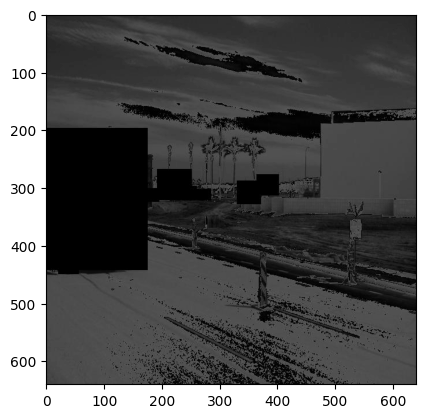

In [23]:
path_list = get_path('/content/datasets/eval/images')
for image_path in path_list :
  input_data = preprocess_input(image_path)
  break

plt.imshow(input_data[0], cmap='gray', vmin=0, vmax=1)
print(input_data.shape)

#### Code to run inference on the earlier image

In [26]:
#loading trained model
model = tf.keras.models.load_model('/content/encoder_model')

1/1 [==============================] - 0s 191ms/step
(1, 640, 640, 1)


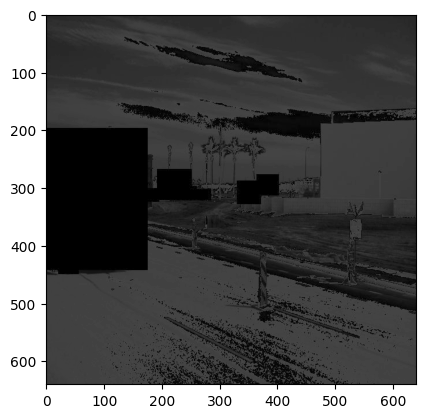

In [27]:
#running inference
output_array = model.predict(input_data)
print(output_array.shape)
#plotting image
plt.imshow(output_array[0], cmap='gray', vmin=0, vmax=1)

## Building reconstruction error distribution.
- we are using the distrbution to understand how many standard deviations away is the image / sub image from normal to classify as an anomaly

#### Functions to split image

In [43]:
# this will break the image into smaller images to be stacked

def split_and_stack_image(image_array, output_shape=(64, 64)):
    input_height, input_width, _ = image_array.shape
    num_rows = input_height // output_shape[0]
    num_cols = input_width // output_shape[1]
    stacked_images = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * output_shape[0]
            end_row = start_row + output_shape[0]
            start_col = j * output_shape[1]
            end_col = start_col + output_shape[1]

            small_image = image_array[start_row:end_row, start_col:end_col]
            stacked_images.append(small_image)

    stacked_array = np.stack(stacked_images, axis = 0)
    return stacked_array

#### Function to calculate MSE for split images

In [39]:
def calculate_mse(original_image_array_list, model_output_array_list, output_shape = 64):
  mse_list = []
  for i in range(len(original_image_array_list)):
    mse_output = np.mean((original_image_array_list[i] - model_output_array_list[i])**2)
    mse_list.append(mse_output)
  return mse_list

#### Functions to calculate mean, standard deviation and Z score

In [79]:
def min_max_scale(combined_lists):
  combined_array = np.array(combined_lists)
  output_array = (combined_array - np.min(combined_array)) / (np.max(combined_array) - np.min(combined_array))
  return output_array

In [80]:
def dist_stat(combined_lists_array):
  mean = np.mean(combined_lists_array)
  std_dev = np.std(combined_lists_array)
  z_scores = (combined_lists_array - mean) / std_dev
  return mean , std_dev, z_scores

#### Function to check for anomalies

In [81]:
def anomaly_checker(z_scores, threshold = 5):
  anomalies = np.where(z_scores > threshold)[0]
  return anomalies

#### run above functions to create z score distribution and relevant visualizations

In [ ]:
model = tf.keras.models.load_model('/content/encoder_model')

In [ ]:
path_list = get_path('/content/datasets/eval/images')
combined_mse_values = []
i = 0
for image_path in tqdm(path_list) :
  input_data = preprocess_input(image_path)
  output_array = model.predict(input_data)
  mini_input_images = split_and_stack_image(input_data[0])
  mini_output_images = split_and_stack_image(output_array[0])
  mse_list = calculate_mse(mini_input_images,mini_output_images)
  combined_mse_values += mse_list

Text(0.5, 1.0, 'Distribution of Scaled MSE Values with Anomalies')

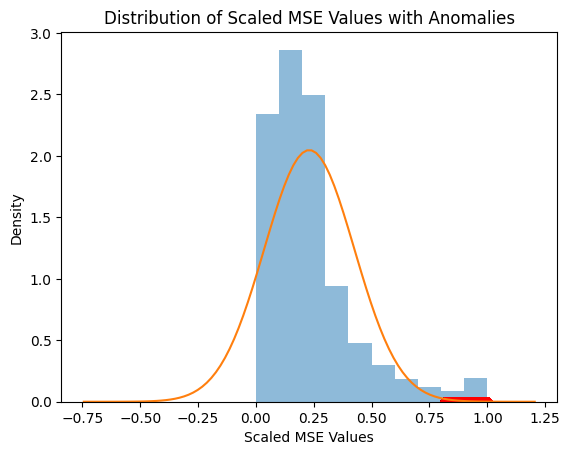

In [89]:
scaled_mse = min_max_scale(combined_mse_values)
mean , std_dev, z_scores = dist_stat(scaled_mse)
anomalies = anomaly_checker(z_scores, threshold = 3)
x_vals = np.linspace(mean - 5 * std_dev, mean + 5 * std_dev, 100)
y_vals = norm.pdf(x_vals, mean, std_dev)
plt.hist(scaled_mse, bins=10, density=True, alpha=0.5, label="MSE Histogram")
plt.plot(x_vals, y_vals, label="Normal Distribution")
plt.scatter(scaled_mse[anomalies], np.zeros_like(anomalies), color='red', label="Anomalies")
plt.xlabel("Scaled MSE Values")
plt.ylabel("Density")
plt.title("Distribution of Scaled MSE Values with Anomalies")


In [90]:
distribution_dict = {'mean': mean,'deviation':std_dev}
distribution_dict_path = "distribution_metrics.json"

with open(distribution_dict_path, "w") as dist_file:
    json.dump(distribution_dict, dist_file, indent=4)
